In [1]:
# Initialize Otter
import otter
grader = otter.Notebook("hw3.ipynb")

# Food Safety
## Cleaning and Exploring Data with Pandas


## Objective

In this project, we will investigate restaurant food safety scores for restaurants in San Francisco. The scores and violation information have been [made available by the San Francisco Department of Public Health](https://data.sfgov.org/Health-and-Social-Services/Restaurant-Scores-LIVES-Standard/pyih-qa8i). The main goal for this assignment is perform data cleaning and EDA. 


As we clean and explore these data, we will:
* Reading simple csv files and using Pandas
* Working with data at different levels of granularity
* Identifying the type of data collected, missing values, anomalies, etc.
* Exploring characteristics and distributions of individual variables

In [1]:
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
plt.style.use('fivethirtyeight')

import zipfile
from pathlib import Path
import os # Used to interact with the file system

## Obtaining the Data

### File Systems and I/O



In general, we will focus on using python commands to investigate files.  However, it can sometimes be easier to use shell commands in your local operating system.  The following cells demonstrate how to do this.

In [3]:
from pathlib import Path
data_dir = Path('.')
data_dir.mkdir(exist_ok = True)
file_path = data_dir / Path('data.zip')
dest_path = file_path

After running the cell above, if you list the contents of the directory containing this notebook, you should see `data.zip`.

*Note*: The command below starts with an `!`. This tells our Jupyter notebook to pass this command to the operating system. In this case, the command is the `ls` Unix command which lists files in the current directory.

In [4]:
!ls

data  data.zip	ds100_utils.py	hw3.ipynb  pics  __pycache__  sf.png  tests


## 1: Loading Food Safety Data

We have data, but we don't have any specific questions about the data yet. Let's focus on understanding the structure of the data; this involves answering questions such as:

* Is the data in a standard format or encoding?
* Is the data organized in records?
* What are the fields in each record?

Let's start by looking at the contents of `data.zip`. It's not just a single file but rather a compressed directory of multiple files. We could inspect it by uncompressing it using a shell command such as `!unzip data.zip`, but in this project we're going to do almost everything in Python for maximum portability.

## Looking Inside and Extracting the Zip Files

The following codeblocks are setup. Simply run the cells; **do not modify them**. Question 1a is where you will start to write code.

Here, we assign `my_zip` to a `zipfile.Zipfile` object representing `data.zip`, and assign `list_names` to a list of all the names of the contents in `data.zip`.

In [5]:
my_zip = zipfile.ZipFile(dest_path, 'r')
list_names = my_zip.namelist()
list_names

['data/',
 'data/bus.csv',
 'data/ins.csv',
 'data/ins2vio.csv',
 'data/vio.csv',
 'data/sf_zipcodes.json',
 'data/legend.csv']

You may notice that we did not write `zipfile.ZipFile('data.zip', ...)`. Instead, we used `zipfile.ZipFile(dest_path, ...)`. In general, we **strongly suggest having your filenames hard coded as string literals only once** in a notebook. It is very dangerous to hard code things twice because if you change one but forget to change the other, you can end up with bugs that are very hard to find.

Now we display the files' names and their sizes.

In [6]:
my_zip = zipfile.ZipFile(dest_path, 'r')
for info in my_zip.infolist():
    print('{}\t{}'.format(info.filename, info.file_size))

data/	0
data/bus.csv	665365
data/ins.csv	1860919
data/ins2vio.csv	1032799
data/vio.csv	4213
data/sf_zipcodes.json	474
data/legend.csv	120


Often when working with zipped data, we'll never unzip the actual zipfile. This saves space on our local computer. However, for this project the files are small, so we're just going to unzip everything. This has the added benefit that you can look inside the csv files using a text editor, which might be handy for understanding the structure of the files. The cell below will unzip the csv files into a subdirectory called `data`.

In [7]:
data_dir = Path('.')
my_zip.extractall(data_dir)
!ls {data_dir / Path("data")}

bus.csv  ins2vio.csv  ins.csv  legend.csv  sf_zipcodes.json  vio.csv


The cell above created a folder called `data`, and in it there should be five CSV files. Let's open up `legend.csv` to see its contents. To do this, click on the jupyterhub logo on the top left, then navigate to `sp21/hw/hw3/data/` and click on `legend.csv`. The file will open up in another tab. You should see something that looks like:

    "Minimum_Score","Maximum_Score","Description"
    0,70,"Poor"
    71,85,"Needs Improvement"
    86,90,"Adequate"
    91,100,"Good"

The `legend.csv` file does indeed look like a well-formed CSV file. Let's check the other three files. Rather than opening up each file manually, let's use Python to print out the first 5 lines of each. The `ds100_utils` library has a method called `head` that will allow you to retrieve the first N lines of a file as a list. For example `ds100_utils.head('data/legend.csv', 5)` will return the first 5 lines of "data/legend.csv". Try using this function to print out the first 5 lines of all six files that we just extracted from the zipfile.

In [8]:
import ds100_utils

data_dir = "./"
for f in list_names:
    if not os.path.isdir(f):
        print(ds100_utils.head(data_dir + f, 5), "\n")

['"business id column","name","address","city","state","postal_code","latitude","longitude","phone_number"\n', '"1000","HEUNG YUEN RESTAURANT","3279 22nd St","San Francisco","CA","94110","37.755282","-122.420493","-9999"\n', '"100010","ILLY CAFFE SF_PIER 39","PIER 39  K-106-B","San Francisco","CA","94133","-9999","-9999","+14154827284"\n', '"100017","AMICI\'S EAST COAST PIZZERIA","475 06th St","San Francisco","CA","94103","-9999","-9999","+14155279839"\n', '"100026","LOCAL CATERING","1566 CARROLL AVE","San Francisco","CA","94124","-9999","-9999","+14155860315"\n'] 

['"iid","date","score","type"\n', '"100010_20190329","03/29/2019 12:00:00 AM","-1","New Construction"\n', '"100010_20190403","04/03/2019 12:00:00 AM","100","Routine - Unscheduled"\n', '"100017_20190417","04/17/2019 12:00:00 AM","-1","New Ownership"\n', '"100017_20190816","08/16/2019 12:00:00 AM","91","Routine - Unscheduled"\n'] 

['"iid","vid"\n', '"97975_20190725","103124"\n', '"85986_20161011","103114"\n', '"95754_2019032

## Reading in and Verifying Data

Based on the above information, let's attempt to load `bus.csv`, `ins2vio.csv`, `ins.csv`, and `vio.csv` into pandas dataframes with the following names: `bus`, `ins2vio`, `ins`, and `vio` respectively.

*Note:* Because of character encoding issues one of the files (`bus`) will require an additional argument `encoding='ISO-8859-1'` when calling `pd.read_csv`. At some point in your future, you should read all about [character encodings](https://diveintopython3.problemsolving.io/strings.html). We won't discuss these in detail in DS100.

In [9]:
# path to directory containing data
dsDir = Path('data')

bus = pd.read_csv(dsDir/'bus.csv', encoding='ISO-8859-1')
ins2vio = pd.read_csv(dsDir/'ins2vio.csv')
ins = pd.read_csv(dsDir/'ins.csv')
vio = pd.read_csv(dsDir/'vio.csv')

#This code is essential for the autograder to function properly. Do not edit
ins_test = ins

Now that you've read in the files, let's try some `pd.DataFrame` methods ([docs](https://pandas.pydata.org/pandas-docs/version/0.21/generated/pandas.DataFrame.html)).
Use the `DataFrame.head` method to show the top few lines of the `bus`, `ins`, and `vio` dataframes. To show multiple return outputs in one single cell, you can use `display()`. Currently, running the cell below will display the first few lines of the `bus` dataframe. 

In [10]:
bus.head()

,business id column,name,address,city,state,postal_code,latitude,longitude,phone_number
0,1000,HEUNG YUEN RESTAURANT,3279 22nd St,San Francisco,CA,94110,37.755282,-122.420493,-9999
1,100010,ILLY CAFFE SF_PIER 39,PIER 39 K-106-B,San Francisco,CA,94133,-9999.000000,-9999.000000,14154827284
2,100017,AMICI'S EAST COAST PIZZERIA,475 06th St,San Francisco,CA,94103,-9999.000000,-9999.000000,14155279839
3,100026,LOCAL CATERING,1566 CARROLL AVE,San Francisco,CA,94124,-9999.000000,-9999.000000,14155860315
4,100030,OUI OUI! MACARON,2200 JERROLD AVE STE C,San Francisco,CA,94124,-9999.000000,-9999.000000,14159702675


The `DataFrame.describe` method can also be handy for computing summaries of numeric columns of our dataframes. Try it out with each of our 4 dataframes. Below, we have used the method to give a summary of the `bus` dataframe. 

In [11]:
bus.describe()

,business id column,latitude,longitude,phone_number
count,6253.000000,6253.000000,6253.000000,6.253000e+03
mean,60448.948984,-5575.337966,-5645.817699,4.701819e+09
std,36480.132445,4983.390142,4903.993683,6.667508e+09
min,19.000000,-9999.000000,-9999.000000,-9.999000e+03
25%,18399.000000,-9999.000000,-9999.000000,-9.999000e+03
50%,75685.000000,-9999.000000,-9999.000000,-9.999000e+03
75%,90886.000000,37.776494,-122.421553,1.415533e+10
max,102705.000000,37.824494,0.000000,1.415988e+10


Now, we perform some sanity checks for you to verify that the data was loaded with the correct structure. Run the following cells to load some basic utilities (you do not need to change these at all):

First, we check the basic structure of the data frames you created:

In [12]:
assert all(bus.columns == ['business id column', 'name', 'address', 'city', 'state', 'postal_code',
                           'latitude', 'longitude', 'phone_number'])
assert 6250 <= len(bus) <= 6260

assert all(ins.columns == ['iid', 'date', 'score', 'type'])
assert 26660 <= len(ins) <= 26670

assert all(vio.columns == ['description', 'risk_category', 'vid'])
assert 60 <= len(vio) <= 65

assert all(ins2vio.columns == ['iid', 'vid'])
assert 40210 <= len(ins2vio) <= 40220

Next we'll check that the statistics match what we expect. The following are hard-coded statistical summaries of the correct data.

In [13]:
bus_summary = pd.DataFrame(**{'columns': ['business id column', 'latitude', 'longitude'],
 'data': {'business id column': {'50%': 75685.0, 'max': 102705.0, 'min': 19.0},
  'latitude': {'50%': -9999.0, 'max': 37.824494, 'min': -9999.0},
  'longitude': {'50%': -9999.0,
   'max': 0.0,
   'min': -9999.0}},
 'index': ['min', '50%', 'max']})

ins_summary = pd.DataFrame(**{'columns': ['score'],
 'data': {'score': {'50%': 76.0, 'max': 100.0, 'min': -1.0}},
 'index': ['min', '50%', 'max']})

vio_summary = pd.DataFrame(**{'columns': ['vid'],
 'data': {'vid': {'50%': 103135.0, 'max': 103177.0, 'min': 103102.0}},
 'index': ['min', '50%', 'max']})

from IPython.display import display

print('What we expect from your Businesses dataframe:')
display(bus_summary)
print('What we expect from your Inspections dataframe:')
display(ins_summary)
print('What we expect from your Violations dataframe:')
display(vio_summary)

What we expect from your Businesses dataframe:


,business id column,latitude,longitude
min,19.0,-9999.000000,-9999.0
50%,75685.0,-9999.000000,-9999.0
max,102705.0,37.824494,0.0


What we expect from your Inspections dataframe:


,score
min,-1.0
50%,76.0
max,100.0


What we expect from your Violations dataframe:


,vid
min,103102.0
50%,103135.0
max,103177.0


The code below defines a testing function that we'll use to verify that your data has the same statistics as what we expect. Run these cells to define the function. The `df_allclose` function has this name because we are verifying that all of the statistics for your dataframe are close to the expected values. Why not `df_allequal`? It's a bad idea in almost all cases to compare two floating point values like 37.780435, as rounding error can cause spurious failures.

In [14]:
"""Run this cell to load this utility comparison function that we will use in various
tests below (both tests you can see and those we run internally for grading).

Do not modify the function in any way.
"""


def df_allclose(actual, desired, columns=None, rtol=5e-2):
    """Compare selected columns of two dataframes on a few summary statistics.
    
    Compute the min, median and max of the two dataframes on the given columns, and compare
    that they match numerically to the given relative tolerance.
    
    If they don't match, an AssertionError is raised (by `numpy.testing`).
    """    
    # summary statistics to compare on
    stats = ['min', '50%', 'max']
    
    # For the desired values, we can provide a full DF with the same structure as
    # the actual data, or pre-computed summary statistics.
    # We assume a pre-computed summary was provided if columns is None. In that case, 
    # `desired` *must* have the same structure as the actual's summary
    if columns is None:
        des = desired
        columns = desired.columns
    else:
        des = desired[columns].describe().loc[stats]

    # Extract summary stats from actual DF
    act = actual[columns].describe().loc[stats]

    return np.allclose(act, des, rtol)

<br/><br/><br/>

---

<br/><br/><br/>

## Question 1a: Identifying Issues with the Data

<!-- BEGIN QUESTION -->

Use the `head` command on your three files again. This time, describe at least one potential problem with the data you see. Consider issues with missing values and bad data.

<!--
BEGIN QUESTION
name: q1a
manual: True
points: 1
-->

The values in the longtitude, latitude, postal_code and phone_number columns of the bus dataframe include nonsensical data. Namely, that latitudes should range from -90 to 90 and longtitudes should range from -180 to 180. However, some entires have -9999.000000 as their coordinates. Further, there are some entries of -9999 as the phone number and postal code as well. These bad data can cause bias and lead to inaccurate analysis.

<!-- END QUESTION -->



We will explore each file in turn, including determining its granularity and primary keys and exploring many of the variables individually. Let's begin with the businesses file, which has been read into the `bus` dataframe.

<br/><br/><br/>

---

<br/><br/><br/>

## Question 1b: Examining the Business Data File

From its name alone, we expect the `bus.csv` file to contain information about the restaurants. Let's investigate the granularity of this dataset.

In [15]:
bus.head()

,business id column,name,address,city,state,postal_code,latitude,longitude,phone_number
0,1000,HEUNG YUEN RESTAURANT,3279 22nd St,San Francisco,CA,94110,37.755282,-122.420493,-9999
1,100010,ILLY CAFFE SF_PIER 39,PIER 39 K-106-B,San Francisco,CA,94133,-9999.000000,-9999.000000,14154827284
2,100017,AMICI'S EAST COAST PIZZERIA,475 06th St,San Francisco,CA,94103,-9999.000000,-9999.000000,14155279839
3,100026,LOCAL CATERING,1566 CARROLL AVE,San Francisco,CA,94124,-9999.000000,-9999.000000,14155860315
4,100030,OUI OUI! MACARON,2200 JERROLD AVE STE C,San Francisco,CA,94124,-9999.000000,-9999.000000,14159702675


The `bus` dataframe contains a column called `business id column` which probably corresponds to a unique business id.  However, we will first rename that column to `bid` for simplicity.

**Note**: In practice we might want to do this renaming when the table is loaded but for grading purposes we will do it here.


In [16]:
bus = bus.rename(columns={"business id column": "bid"})
bus

,bid,name,address,city,state,postal_code,latitude,longitude,phone_number
0,1000,HEUNG YUEN RESTAURANT,3279 22nd St,San Francisco,CA,94110,37.755282,-122.420493,-9999
1,100010,ILLY CAFFE SF_PIER 39,PIER 39 K-106-B,San Francisco,CA,94133,-9999.000000,-9999.000000,14154827284
2,100017,AMICI'S EAST COAST PIZZERIA,475 06th St,San Francisco,CA,94103,-9999.000000,-9999.000000,14155279839
3,100026,LOCAL CATERING,1566 CARROLL AVE,San Francisco,CA,94124,-9999.000000,-9999.000000,14155860315
4,100030,OUI OUI! MACARON,2200 JERROLD AVE STE C,San Francisco,CA,94124,-9999.000000,-9999.000000,14159702675
...,...,...,...,...,...,...,...,...,...
6248,99948,SUSIECAKES BAKERY,3509 CALIFORNIA ST,San Francisco,CA,94118,-9999.000000,-9999.000000,14150452253
6249,99988,HINODEYA SOMA,303 02nd ST STE 102,San Francisco,CA,94107,-9999.000000,-9999.000000,-9999
6250,99991,TON TON,422 GEARY ST,San Francisco,CA,94102,-9999.000000,-9999.000000,14155531280
6251,99992,URBAN EXPRESS KITCHENS LLC,475 06th ST,San Francisco,CA,94103,-9999.000000,-9999.000000,14150368085


Examining the entries in `bus`, is the `bid` unique for each record (i.e. each row of data)? Your code should compute the answer, i.e. don't just hard code `True` or `False`.

Hint: use `value_counts()` or `unique()` to determine if the `bid` series has any duplicates.

<!--
BEGIN QUESTION
name: q1b
points: 1
-->

In [17]:
is_bid_unique = sum(bus["bid"].value_counts() == 1) == len(bus)
is_bid_unique

True

In [18]:
grader.check("q1b")

q1b passed!

<br/><br/><br/>

---


## Question 1c

We will now work with some important fields in `bus`. In the two cells below create the following **two numpy arrays**:

1. Assign `top_names` to the top 5 most frequently used business names, from most frequent to least frequent.
2. Assign `top_addresses` to the top 5 addressses where businesses are located, from most popular to least popular.

Hint: you may find `value_counts()` helpful. 

**Step 1**

<!--
BEGIN QUESTION
name: q1c
points: 2
-->

In [19]:
top_names = np.asarray(bus["name"].value_counts().sort_values(ascending=False)[:5].index)
top_addresses = np.asarray(bus["address"].value_counts().sort_values(ascending=False)[:5].index)
top_names, top_addresses

(array(["Peet's Coffee & Tea", 'Starbucks Coffee', "McDonald's",
        'Jamba Juice', 'STARBUCKS'], dtype=object),
 array(['Off The Grid', '428 11th St', '3251 20th Ave', '2948 Folsom St',
        'Pier 41'], dtype=object))

In [20]:
grader.check("q1c")

q1c passed!

<br/><br/><br/>

---


## Question 1d

Based on the above exploration, answer each of the following questions about `bus` by assigning your answers to the corresponding variables

1. What does each record represent?  
1. What is the minimal primary key?

<!--
BEGIN QUESTION
name: q1d
points: 2
-->

In [21]:
# What does each record represent?  Valid answers are:
#    "One location of a restaurant."
#    "A chain of restaurants."
#    "A city block."
q1e_part1 = "One location of a restaurant."

# What is the minimal primary key? Valid answers are:
#    "bid"
#    "bid, name"
#    "bid, name, address"
q1e_part2 = "bid"

In [22]:
grader.check("q1d")

q1d passed!

<br/><br/><br/>

---

<br/><br/><br/>

# 2: Cleaning the Business Data Postal Codes

The business data contains postal code information that we can use to aggregate the ratings over regions of the city.  Let's examine and clean the postal code field.  The postal code (sometimes also called a ZIP code) partitions the city into regions:

<img src="https://www.usmapguide.com/wp-content/uploads/2019/03/printable-san-francisco-zip-code-map.jpg" alt="ZIP Code Map" style="width: 600px">

<br/><br/><br/>

---


## Question 2a

How many restaurants are in each ZIP code? 

In the cell below, create a **series** where the index is the postal code and the value is the number of records with that postal code in descending order of count. You may need to use `groupby()`, `size()`, or `value_counts()`. Do you notice any odd/invalid zip codes?

<!--
BEGIN QUESTION
name: q2a
points: 2
-->

In [23]:
zip_counts = bus.value_counts("postal_code").sort_values(ascending=False)
print(zip_counts.to_string())

postal_code
94103         562
94110         555
94102         456
94107         408
94133         398
94109         382
94111         259
94122         255
94105         249
94118         231
94115         230
94108         229
94124         218
94114         200
-9999         194
94112         192
94117         189
94123         177
94121         157
94104         142
94132         132
94116          97
94158          90
94134          82
94127          67
94131          49
94130           8
94143           5
94188           2
94013           2
94301           2
CA              2
94101           2
94129           1
94124-1917      1
92672           1
94123-3106      1
94122-1909      1
94014           1
94105-1420      1
00000           1
94080           1
94117-3504      1
941             1
94102-5917      1
941033148       1
941102019       1
94120           1
64110           1
94105-2907      1
94901           1
95117           1
95112           1
95109           1
95105           

In [24]:
grader.check("q2a")

q2a passed!

<br/><br/><br/>

--- 

## Question 2b

Answer the following questions about the `postal_code` column in the `bus` dataframe.

1. The ZIP code column is which of the following type of data:
    1. Quantitative Continuous
    1. Quantitative Discrete
    1. Qualitative Ordinal
    1. Qualitative Nominal    
1. What Python data type is used to represent a ZIP code?

*Note*: ZIP codes and postal codes are the same thing.

Please write your answers in the variables below:

<!--
BEGIN QUESTION
name: q2b
points: 2
-->

In [25]:
# The ZIP code column is which of the following type of data:
#   "Quantitative Continuous" 
#   "Quantitative Discrete"
#   "Qualitative Ordinal"
#   "Qualitative Nominal"
q2b_part1 = "Qualitative Nominal" 

# What Python data type is used to represent a ZIP code? 
#    "str"
#    "int"
#    "bool"
#    "float"
q2b_part2 = "str"

In [26]:
grader.check("q2b")

q2b passed!

<br/><br/><br/>

--- 

## Question 2c

In question 2a we noticed a large number of potentially invalid ZIP codes (e.g., "Ca").  These are likely due to data entry errors.  To get a better understanding of the potential errors in the zip codes we will:

1. Import a list of valid San Francisco ZIP codes by using `pd.read_json` to load the file `data/sf_zipcodes.json` and extract a **series** of type `str` containing the valid ZIP codes.  *Hint: set `dtype` when invoking `read_json`.*
1. Construct a `DataFrame` containing only the businesses which DO NOT have valid ZIP codes.  You will probably want to use the `Series.isin` function. 


**Step 1**

<!--
BEGIN QUESTION
name: q2ci
points: 1
-->

In [27]:
valid_zips = pd.read_json('data/sf_zipcodes.json', dtype=str).squeeze()
valid_zips.head()

0    94102
1    94103
2    94104
3    94105
4    94107
Name: zip_codes, dtype: object

In [28]:
grader.check("q2ci")

q2ci passed!

**Step 2**

<!--
BEGIN QUESTION
name: q2cii
points: 1
-->

In [29]:
invalid_zip_bus = bus[~(bus["postal_code"].isin(valid_zips))]
invalid_zip_bus.head(20)

,bid,name,address,city,state,postal_code,latitude,longitude,phone_number
22,100126,Lamas Peruvian Food Truck,Private Location,San Francisco,CA,-9999,-9999.000000,-9999.000000,-9999
68,100417,"COMPASS ONE, LLC",1 MARKET ST. FL,San Francisco,CA,94105-1420,-9999.000000,-9999.000000,14154324000
96,100660,TEAPENTER,1518 IRVING ST,San Francisco,CA,94122-1909,-9999.000000,-9999.000000,14155868318
109,100781,LE CAFE DU SOLEIL,200 FILLMORE ST,San Francisco,CA,94117-3504,-9999.000000,-9999.000000,14155614215
144,101084,Deli North 200,1 Warriors Way Level 300 North East,San Francisco,CA,94518,-9999.000000,-9999.000000,-9999
156,101129,Vendor Room 200,1 Warriors Way Level 300 South West,San Francisco,CA,-9999,-9999.000000,-9999.000000,-9999
177,101192,Cochinita #2,2 Marina Blvd Fort Mason,San Francisco,CA,-9999,-9999.000000,-9999.000000,14150429222
276,102014,"DROPBOX (Section 3, Floor 7)",1800 Owens St,San Francisco,CA,-9999,-9999.000000,-9999.000000,-9999
295,102245,Vessell CA Operations (#4),2351 Mission St,San Francisco,CA,-9999,-9999.000000,-9999.000000,-9999
298,10227,The Napper Tandy,3200 24th St,San Francisco,CA,-9999,37.752581,-122.416482,-9999


In [30]:
grader.check("q2cii")

q2cii passed!

<br/><br/><br/>

--- 

## Question 2d

In the previous question, many of the businesses had a common invalid postal code that was likely used to encode a MISSING postal code.  Do they all share a potentially "interesting address"?

In the following cell, construct a **series** that counts the number of businesses at each `address` that have this single likely MISSING postal code value.  Order the series in descending order by count. 

After examining the output, please answer the following question (2e) by filling in the appropriate variable. If we were to drop businesses with MISSING postal code values would a particular class of business be affected?  If you are unsure try to search the web for the most common addresses.


<!--
BEGIN QUESTION
name: q2d
points: 3
-->

In [31]:
missing_zip_address_count = invalid_zip_bus[invalid_zip_bus["postal_code"] == "-9999"].groupby("address").size().sort_values(ascending=False)
missing_zip_address_count.head()

address
Off The Grid                  39
Off the Grid                  10
OTG                            4
Approved Locations             3
Approved Private Locations     3
dtype: int64

In [32]:
grader.check("q2d")

q2d passed!

<br/><br/><br/>

--- 

## Question 2e

**True or False**:  *If we were to drop businesses with MISSING postal code values, a particular class of business will be affected.*

<!--
BEGIN QUESTION
name: q2e
points: 2
-->

In [33]:
# True or False: 
#  If we were to drop businesses with MISSING postal code values 
#   a particular class of business be affected.
q2e_true_or_false = True

In [34]:
grader.check("q2e")

q2e passed!

<br/><br/><br/>

--- 

## Question 2f

Examine the `invalid_zip_bus` dataframe we computed above and look at the businesses that DO NOT have the special MISSING ZIP code value.  Some of the invalid postal codes are just the full 9 digit code rather than the first 5 digits.  Create a new column named `postal5` in the original `bus` dataframe which contains only the first 5 digits of the `postal_code` column.   Finally, for any of the `postal5` ZIP code entries that were not a valid San Fransisco ZIP Code (according to `valid_zips`) set the entry to `None`.  


<!--
BEGIN QUESTION
name: q2f
points: 2
-->

In [35]:
bus["postal5"] = bus['postal_code'].str[:5]
bus["check"] = bus["postal5"].isin(valid_zips)
bus.loc[bus.check == False, 'postal5'] = None
bus = bus.drop("check", axis=1)
# Checking the corrected postal5 column
bus.loc[invalid_zip_bus.index, ['bid', 'name', 'postal_code', 'postal5']]

,bid,name,postal_code,postal5
22,100126,Lamas Peruvian Food Truck,-9999,None
68,100417,"COMPASS ONE, LLC",94105-1420,94105
96,100660,TEAPENTER,94122-1909,94122
109,100781,LE CAFE DU SOLEIL,94117-3504,94117
144,101084,Deli North 200,94518,None
...,...,...,...,...
6173,99369,HOTEL BIRON,94102-5917,94102
6174,99376,Mashallah Halal Food truck Ind,-9999,None
6199,99536,FAITH SANDWICH #2,94105-2907,94105
6204,99681,Twister,95112,None


In [36]:
grader.check("q2f")

q2f passed!

<br/><br/><br/>

---

<br/><br/><br/>

# 3: Investigate the Inspection Data

Let's now turn to the inspection DataFrame. Earlier, we found that `ins` has 4 columns named 
`iid`, `score`, `date` and `type`.  In this section, we determine the granularity of `ins` and investigate the kinds of information provided for the inspections. 

Let's start by looking again at the first 5 rows of `ins` to see what we're working with.

In [37]:
ins.head(5)

,iid,date,score,type
0,100010_20190329,03/29/2019 12:00:00 AM,-1,New Construction
1,100010_20190403,04/03/2019 12:00:00 AM,100,Routine - Unscheduled
2,100017_20190417,04/17/2019 12:00:00 AM,-1,New Ownership
3,100017_20190816,08/16/2019 12:00:00 AM,91,Routine - Unscheduled
4,100017_20190826,08/26/2019 12:00:00 AM,-1,Reinspection/Followup


<br/><br/><br/>

---

## Question 3a

The column `iid` probably corresponds to an inspection id.  Is it a primary key?  Write an expression (line of code) that evaluates to `True` or `False` based on whether all the values are unique.


<!--
BEGIN QUESTION
name: q3a
points: 1
-->

In [38]:
is_ins_iid_a_primary_key = True

In [39]:
grader.check("q3a")

q3a passed!

<br/><br/><br/>

---

## Question 3b

The column `iid` appears to be the composition of two numbers and the first number looks like a business id.  

**Part 1.**: Create a new column called `bid` in the `ins` dataframe containing just the business id.  You will want to use `ins['iid'].str` operations to do this.  Also be sure to convert the type of this column to `int`

**Part 2.**: Then compute how many values in this new column are invalid business ids (i.e. do not appear in the `bus['bid']` column). This is verifying a foreign key relationship. Consider using the `pd.Series.isin` function.

**Part 3.**: Answer True or False, `ins['bid']` is a foreign key reference to `bus['bid']`.


**No python `for` loops or list comprehensions required!**

**Part 1**

<!--
BEGIN QUESTION
name: q3bi
points: 1
-->

In [40]:
ins["bid"] = ins["iid"].str.split("_").str[0].apply(int)
ins

,iid,date,score,type,bid
0,100010_20190329,03/29/2019 12:00:00 AM,-1,New Construction,100010
1,100010_20190403,04/03/2019 12:00:00 AM,100,Routine - Unscheduled,100010
2,100017_20190417,04/17/2019 12:00:00 AM,-1,New Ownership,100017
3,100017_20190816,08/16/2019 12:00:00 AM,91,Routine - Unscheduled,100017
4,100017_20190826,08/26/2019 12:00:00 AM,-1,Reinspection/Followup,100017
...,...,...,...,...,...
26658,999_20180924,09/24/2018 12:00:00 AM,-1,Routine - Scheduled,999
26659,999_20181102,11/02/2018 12:00:00 AM,-1,Reinspection/Followup,999
26660,999_20190909,09/09/2019 12:00:00 AM,80,Routine - Unscheduled,999
26661,99_20171207,12/07/2017 12:00:00 AM,82,Routine - Unscheduled,99


In [41]:
grader.check("q3bi")

q3bi passed!

**Part 2**

<!--
BEGIN QUESTION
name: q3bii
points: 1
-->

In [42]:
invalid_bid_count = sum(~(ins["bid"].isin(bus["bid"])))
invalid_bid_count

0

In [43]:
grader.check("q3bii")

q3bii passed!

**Part 3**

<!--
BEGIN QUESTION
name: q3biii
points: 1
-->

In [44]:
# True or False: The column ins['bid'] is a foreign key 
#   referencing the bus['bid'] primary key.

q3b_is_foreign_key = True

In [45]:
grader.check("q3biii")

q3biii passed!

<br/><br/><br/>

---

## Question 3c

What if we are interested in a time component of the inspection data?  We need to examine the date column of each inspection. 

**Part 1:** What is the type of the individual `ins['date']` entries? You may want to grab the very first entry and use the `type` function in python. 

**Part 2:** Use `pd.to_datetime` to create a new `ins['timestamp']` column containing of `pd.Timestamp` objects.  These will allow us to do more date manipulation.

**Part 3:** What are the earliest and latest dates in our inspection data?  *Hint: you can use `min` and `max` on dates of the correct type.*

**Part 4:** We probably want to examine the inspections by year. Create an additional `ins['year']` column containing just the year of the inspection.  Consider using `pd.Series.dt.year` to do this.

**No python `for` loops or list comprehensions required!**

**Part 1**

<!--
BEGIN QUESTION
name: q3ci
points: 1
-->

In [46]:
ins_date_type = type(ins["date"][0])
ins_date_type

str

In [47]:
grader.check("q3ci")

q3ci passed!

**Part 2**

<!--
BEGIN QUESTION
name: q3cii
points: 1
-->

In [48]:
ins['timestamp'] = pd.to_datetime(ins['date'])
ins

,iid,date,score,type,bid,timestamp
0,100010_20190329,03/29/2019 12:00:00 AM,-1,New Construction,100010,2019-03-29
1,100010_20190403,04/03/2019 12:00:00 AM,100,Routine - Unscheduled,100010,2019-04-03
2,100017_20190417,04/17/2019 12:00:00 AM,-1,New Ownership,100017,2019-04-17
3,100017_20190816,08/16/2019 12:00:00 AM,91,Routine - Unscheduled,100017,2019-08-16
4,100017_20190826,08/26/2019 12:00:00 AM,-1,Reinspection/Followup,100017,2019-08-26
...,...,...,...,...,...,...
26658,999_20180924,09/24/2018 12:00:00 AM,-1,Routine - Scheduled,999,2018-09-24
26659,999_20181102,11/02/2018 12:00:00 AM,-1,Reinspection/Followup,999,2018-11-02
26660,999_20190909,09/09/2019 12:00:00 AM,80,Routine - Unscheduled,999,2019-09-09
26661,99_20171207,12/07/2017 12:00:00 AM,82,Routine - Unscheduled,99,2017-12-07


In [49]:
grader.check("q3cii")

q3cii passed!

**Part 3**

<!--
BEGIN QUESTION
name: q3ciii
points: 1
-->

In [50]:
earliest_date = min(ins['timestamp'])
latest_date = max(ins['timestamp'])

print("Earliest Date:", earliest_date)
print("Latest Date:", latest_date)

Earliest Date: 2016-10-04 00:00:00
Latest Date: 2019-11-28 00:00:00


In [51]:
grader.check("q3ciii")

q3ciii passed!

**Part 4**

<!--
BEGIN QUESTION
name: q3civ
points: 1
-->

In [52]:
ins['year'] = ins.timestamp.dt.year
ins

,iid,date,score,type,bid,timestamp,year
0,100010_20190329,03/29/2019 12:00:00 AM,-1,New Construction,100010,2019-03-29,2019
1,100010_20190403,04/03/2019 12:00:00 AM,100,Routine - Unscheduled,100010,2019-04-03,2019
2,100017_20190417,04/17/2019 12:00:00 AM,-1,New Ownership,100017,2019-04-17,2019
3,100017_20190816,08/16/2019 12:00:00 AM,91,Routine - Unscheduled,100017,2019-08-16,2019
4,100017_20190826,08/26/2019 12:00:00 AM,-1,Reinspection/Followup,100017,2019-08-26,2019
...,...,...,...,...,...,...,...
26658,999_20180924,09/24/2018 12:00:00 AM,-1,Routine - Scheduled,999,2018-09-24,2018
26659,999_20181102,11/02/2018 12:00:00 AM,-1,Reinspection/Followup,999,2018-11-02,2018
26660,999_20190909,09/09/2019 12:00:00 AM,80,Routine - Unscheduled,999,2019-09-09,2019
26661,99_20171207,12/07/2017 12:00:00 AM,82,Routine - Unscheduled,99,2017-12-07,2017


In [53]:
grader.check("q3civ")

q3civ passed!

In [54]:
ins.head()

,iid,date,score,type,bid,timestamp,year
0,100010_20190329,03/29/2019 12:00:00 AM,-1,New Construction,100010,2019-03-29,2019
1,100010_20190403,04/03/2019 12:00:00 AM,100,Routine - Unscheduled,100010,2019-04-03,2019
2,100017_20190417,04/17/2019 12:00:00 AM,-1,New Ownership,100017,2019-04-17,2019
3,100017_20190816,08/16/2019 12:00:00 AM,91,Routine - Unscheduled,100017,2019-08-16,2019
4,100017_20190826,08/26/2019 12:00:00 AM,-1,Reinspection/Followup,100017,2019-08-26,2019


<br/><br/><br/>

---

## Question 3d

What is the relationship between the type of inspection over the 2016 to 2019 timeframe? 

**Part 1**

Construct the following table by
1. Using the `pivot_table` containing the number (`size`) of inspections for the given `type` and `year`.
1. Adding an extra `Total` column to the result using `sum`
1. Sort the results in descending order by the `Total`.

<table border="1" class="dataframe">  <thead>    <tr style="text-align: right;">      <th>year</th>      <th>2016</th>      <th>2017</th>      <th>2018</th>      <th>2019</th>      <th>Total</th>    </tr>    <tr>      <th>type</th>      <th></th>      <th></th>      <th></th>      <th></th>      <th></th>    </tr>  </thead>  <tbody>    <tr>      <th>Routine - Unscheduled</th>      <td>966</td>      <td>4057</td>      <td>4373</td>      <td>4681</td>      <td>14077</td>    </tr>    <tr>      <th>Reinspection/Followup</th>      <td>445</td>      <td>1767</td>      <td>1935</td>      <td>2292</td>      <td>6439</td>    </tr>    <tr>      <th>New Ownership</th>      <td>99</td>      <td>506</td>      <td>528</td>      <td>459</td>      <td>1592</td>    </tr>    <tr>      <th>Complaint</th>      <td>91</td>      <td>418</td>      <td>512</td>      <td>437</td>      <td>1458</td>    </tr>    <tr>      <th>New Construction</th>      <td>102</td>      <td>485</td>      <td>218</td>      <td>189</td>      <td>994</td>    </tr>    <tr>      <th>Non-inspection site visit</th>      <td>51</td>      <td>276</td>      <td>253</td>      <td>231</td>      <td>811</td>    </tr>    <tr>      <th>New Ownership - Followup</th>      <td>0</td>      <td>45</td>      <td>219</td>      <td>235</td>      <td>499</td>    </tr>    <tr>      <th>Structural Inspection</th>      <td>1</td>      <td>153</td>      <td>50</td>      <td>190</td>      <td>394</td>    </tr>    <tr>      <th>Complaint Reinspection/Followup</th>      <td>19</td>      <td>68</td>      <td>70</td>      <td>70</td>      <td>227</td>    </tr>    <tr>      <th>Foodborne Illness Investigation</th>      <td>1</td>      <td>29</td>      <td>50</td>      <td>35</td>      <td>115</td>    </tr>    <tr>      <th>Routine - Scheduled</th>      <td>0</td>      <td>9</td>      <td>8</td>      <td>29</td>      <td>46</td>    </tr>    <tr>      <th>Administrative or Document Review</th>      <td>2</td>      <td>1</td>      <td>1</td>      <td>0</td>      <td>4</td>    </tr>    <tr>      <th>Multi-agency Investigation</th>      <td>0</td>      <td>0</td>      <td>1</td>      <td>2</td>      <td>3</td>    </tr>    <tr>      <th>Special Event</th>      <td>0</td>      <td>3</td>      <td>0</td>      <td>0</td>      <td>3</td>    </tr>    <tr>      <th>Community Health Assessment</th>      <td>1</td>      <td>0</td>      <td>0</td>      <td>0</td>      <td>1</td>    </tr>  </tbody></table>

**No python `for` loops or list comprehensions required!**

In [55]:
ins_pivot = ins.groupby(["year", "type"]).size().reset_index().pivot_table(values = 0, index=["type"], columns=["year"], aggfunc="sum", fill_value=0)
ins_pivot["Total"] = ins_pivot.sum(axis=1)
ins_pivot_sorted = ins_pivot.sort_values("Total", ascending=False)
ins_pivot_sorted

year,2016,2017,2018,2019,Total
type,,,,,
Routine - Unscheduled,966,4057,4373,4681,14077
Reinspection/Followup,445,1767,1935,2292,6439
New Ownership,99,506,528,459,1592
Complaint,91,418,512,437,1458
New Construction,102,485,218,189,994
Non-inspection site visit,51,276,253,231,811
New Ownership - Followup,0,45,219,235,499
Structural Inspection,1,153,50,190,394
Complaint Reinspection/Followup,19,68,70,70,227


In [56]:
grader.check("q3di")

q3di passed!

**Part 2**

Based on the above analysis, which year appears to have had a lot of businesses in newly constructed buildings?
<!--
BEGIN QUESTION
name: q3dii
points: 2
-->

In [57]:
year_of_new_construction = 2017

In [58]:
grader.check("q3dii")

q3dii passed!

<br/><br/><br/>

---

## Question 3e

Let's examine the inspection scores `ins['score']`



In [59]:
ins['score'].value_counts().head()

-1      12632
 100     1993
 96      1681
 92      1260
 94      1250
Name: score, dtype: int64

There are a large number of inspections with the `'score'` of `-1`.   These are probably missing values.  Let's see what type of inspections have scores and which do not. Create the following dataframe using steps similar to the previous question, and assign it to to the variable `ins_missing_score_pivot`.

You should observe that inspection scores appear only to be assigned to `Routine - Unscheduled` inspections.


<table border="1" class="dataframe">  <thead>    <tr style="text-align: right;">      <th>Missing Score</th>      <th>False</th>      <th>True</th>      <th>Total</th>    </tr>    <tr>      <th>type</th>      <th></th>      <th></th>      <th></th>    </tr>  </thead>  <tbody>    <tr>      <th>Routine - Unscheduled</th>      <td>14031</td>      <td>46</td>      <td>14077</td>    </tr>    <tr>      <th>Reinspection/Followup</th>      <td>0</td>      <td>6439</td>      <td>6439</td>    </tr>    <tr>      <th>New Ownership</th>      <td>0</td>      <td>1592</td>      <td>1592</td>    </tr>    <tr>      <th>Complaint</th>      <td>0</td>      <td>1458</td>      <td>1458</td>    </tr>    <tr>      <th>New Construction</th>      <td>0</td>      <td>994</td>      <td>994</td>    </tr>    <tr>      <th>Non-inspection site visit</th>      <td>0</td>      <td>811</td>      <td>811</td>    </tr>    <tr>      <th>New Ownership - Followup</th>      <td>0</td>      <td>499</td>      <td>499</td>    </tr>    <tr>      <th>Structural Inspection</th>      <td>0</td>      <td>394</td>      <td>394</td>    </tr>    <tr>      <th>Complaint Reinspection/Followup</th>      <td>0</td>      <td>227</td>      <td>227</td>    </tr>    <tr>      <th>Foodborne Illness Investigation</th>      <td>0</td>      <td>115</td>      <td>115</td>    </tr>    <tr>      <th>Routine - Scheduled</th>      <td>0</td>      <td>46</td>      <td>46</td>    </tr>    <tr>      <th>Administrative or Document Review</th>      <td>0</td>      <td>4</td>      <td>4</td>    </tr>    <tr>      <th>Multi-agency Investigation</th>      <td>0</td>      <td>3</td>      <td>3</td>    </tr>    <tr>      <th>Special Event</th>      <td>0</td>      <td>3</td>      <td>3</td>    </tr>    <tr>      <th>Community Health Assessment</th>      <td>0</td>      <td>1</td>      <td>1</td>    </tr>  </tbody></table>



In [60]:
ins["Missing Score"] = np.where((ins["score"] == -1), True, False)
pivot = ins.groupby(["Missing Score", "type"]).size().reset_index().pivot_table(values = 0, index=["type"], columns=["Missing Score"], aggfunc="sum", fill_value=0)
pivot["Total"] = pivot.sum(axis=1)
ins_missing_score_pivot = pivot.sort_values("Total", ascending=False)
ins_missing_score_pivot

Missing Score,False,True,Total
type,,,
Routine - Unscheduled,14031,46,14077
Reinspection/Followup,0,6439,6439
New Ownership,0,1592,1592
Complaint,0,1458,1458
New Construction,0,994,994
Non-inspection site visit,0,811,811
New Ownership - Followup,0,499,499
Structural Inspection,0,394,394
Complaint Reinspection/Followup,0,227,227


In [61]:
grader.check("q3e")

q3e passed!

Notice that inspection scores appear only to be assigned to `Routine - Unscheduled` inspections. It is reasonable that for inspection types such as `New Ownership` and `Complaint` to have no associated inspection scores, but we might be curious why there are no inspection scores for the `Reinspection/Followup` inspection type.

<br/><br/><br/>

---

<br/><br/><br/>

# 4: Joining Data Across Tables

In this question we will start to connect data across mulitple tables.  We will be using the `merge` function. 

<br/><br/><br/>

--- 

## Question 4a

Let's figure out which restaurants had the lowest scores. Before we proceed, let's filter out missing scores from `ins` so that negative scores don't influence our results.

In [62]:
ins = ins[ins["score"] > 0]

We'll start by creating a new dataframe called `ins_named`. It should be exactly the same as `ins`, except that it should have the name and address of every business, as determined by the `bus` dataframe. If a `business_id` in `ins` does not exist in `bus`, the name and address should be given as `NaN`. 

*Hint*: Use the merge method to join the `ins` dataframe with the appropriate portion of the `bus` dataframe. See the official [documentation](https://pandas.pydata.org/pandas-docs/stable/user_guide/merging.html) on how to use `merge`.

*Note*: For quick reference, a pandas 'left' join keeps the keys from the left frame, so if `ins` is the left frame, all the keys from `ins` are kept and if a set of these keys don't have matches in the other frame, the columns from the other frame for these "unmatched" key rows contains NaNs.

<!--
BEGIN QUESTION
name: q4a
points: 2
-->

In [63]:
selected_bus = bus[['bid', 'name', 'address']]
ins_named = ins.merge(selected_bus, how='left', left_on='bid', right_on='bid')
ins_named.head()

,iid,date,score,type,bid,timestamp,year,Missing Score,name,address
0,100010_20190403,04/03/2019 12:00:00 AM,100,Routine - Unscheduled,100010,2019-04-03,2019,False,ILLY CAFFE SF_PIER 39,PIER 39 K-106-B
1,100017_20190816,08/16/2019 12:00:00 AM,91,Routine - Unscheduled,100017,2019-08-16,2019,False,AMICI'S EAST COAST PIZZERIA,475 06th St
2,100041_20190520,05/20/2019 12:00:00 AM,83,Routine - Unscheduled,100041,2019-05-20,2019,False,UNCLE LEE CAFE,3608 BALBOA ST
3,100055_20190425,04/25/2019 12:00:00 AM,98,Routine - Unscheduled,100055,2019-04-25,2019,False,Twirl and Dip,335 Martin Luther King Jr. Dr
4,100055_20190912,09/12/2019 12:00:00 AM,82,Routine - Unscheduled,100055,2019-09-12,2019,False,Twirl and Dip,335 Martin Luther King Jr. Dr


In [64]:
grader.check("q4a")

q4a passed!

<br/><br/><br/>

--- 

## Question 4b

Let's look at the 20 businesses with the lowest **median** score.  Order your results by the median score followed by the business id to break ties. The resulting table should look like:


*Hint: You may find the `as_index` argument in the `groupby` method important*. [The documentation is linked here!](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.groupby.html)

<table border="1" class="dataframe">  <thead>    <tr style="text-align: right;">      <th></th>      <th>bid</th>      <th>name</th>      <th>median score</th>    </tr>  </thead>  <tbody>    <tr>      <th>3876</th>      <td>84590</td>      <td>Chaat Corner</td>      <td>54.0</td>    </tr>    <tr>      <th>4564</th>      <td>90622</td>      <td>Taqueria Lolita</td>      <td>57.0</td>    </tr>    <tr>      <th>4990</th>      <td>94351</td>      <td>VBowls LLC</td>      <td>58.0</td>    </tr>    <tr>      <th>2719</th>      <td>69282</td>      <td>New Jumbo Seafood Restaurant</td>      <td>60.5</td>    </tr>    <tr>      <th>222</th>      <td>1154</td>      <td>SUNFLOWER RESTAURANT</td>      <td>63.5</td>    </tr>    <tr>      <th>1991</th>      <td>39776</td>      <td>Duc Loi Supermarket</td>      <td>64.0</td>    </tr>    <tr>      <th>2734</th>      <td>69397</td>      <td>Minna SF Group LLC</td>      <td>64.0</td>    </tr>    <tr>      <th>3291</th>      <td>78328</td>      <td>Golden Wok</td>      <td>64.0</td>    </tr>    <tr>      <th>4870</th>      <td>93150</td>      <td>Chez Beesen</td>      <td>64.0</td>    </tr>    <tr>      <th>4911</th>      <td>93502</td>      <td>Smoky Man</td>      <td>64.0</td>    </tr>    <tr>      <th>5510</th>      <td>98995</td>      <td>Vallarta's Taco Bar</td>      <td>64.0</td>    </tr>    <tr>      <th>1457</th>      <td>10877</td>      <td>CHINA FIRST INC.</td>      <td>64.5</td>    </tr>    <tr>      <th>2890</th>      <td>71310</td>      <td>Golden King Vietnamese Restaurant</td>      <td>64.5</td>    </tr>    <tr>      <th>4352</th>      <td>89070</td>      <td>Lafayette Coffee Shop</td>      <td>64.5</td>    </tr>    <tr>      <th>505</th>      <td>2542</td>      <td>PETER D'S RESTAURANT</td>      <td>65.0</td>    </tr>    <tr>      <th>2874</th>      <td>71008</td>      <td>House of Pancakes</td>      <td>65.0</td>    </tr>    <tr>      <th>818</th>      <td>3862</td>      <td>IMPERIAL GARDEN SEAFOOD RESTAURANT</td>      <td>66.0</td>    </tr>    <tr>      <th>2141</th>      <td>61427</td>      <td>Nick's Foods</td>      <td>66.0</td>    </tr>    <tr>      <th>2954</th>      <td>72176</td>      <td>Wolfes Lunch</td>      <td>66.0</td>    </tr>    <tr>      <th>4367</th>      <td>89141</td>      <td>Cha Cha Cha on Mission</td>      <td>66.5</td>    </tr>  </tbody></table>


<!--
BEGIN QUESTION
name: q4b
points: 3
-->

In [65]:
twenty_lowest_scoring = ins_named[["bid", "name", "score"]].groupby(["bid", "name"], as_index=False).median().sort_values(["score", "bid"]).rename(columns={'score': 'median score'})[:20]
twenty_lowest_scoring

,bid,name,median score
3876,84590,Chaat Corner,54.0
4564,90622,Taqueria Lolita,57.0
4990,94351,VBowls LLC,58.0
2719,69282,New Jumbo Seafood Restaurant,60.5
222,1154,SUNFLOWER RESTAURANT,63.5
1991,39776,Duc Loi Supermarket,64.0
2734,69397,Minna SF Group LLC,64.0
3291,78328,Golden Wok,64.0
4870,93150,Chez Beesen,64.0
4911,93502,Smoky Man,64.0


In [66]:
grader.check("q4b")

q4b passed!

<br/><br/><br/>

--- 

## Question 4c

Let's now examine the descriptions of violations for inspections with `score > 0` and `score < 65`.  Construct a **Series** indexed by the `description` of the violation from the `vio` table with the value being the number of times that violation occured for inspections with the above score range.  Sort the results in descending order of the count.

The first few entries should look like:

```
Unclean or unsanitary food contact surfaces                                  43
High risk food holding temperature                                           42
Unclean or degraded floors walls or ceilings                                 40
Unapproved or unmaintained equipment or utensils                             39
```
You will need to use `merge` twice.

<!--
BEGIN QUESTION
name: q4c
points: 2
-->

In [67]:
merge1 = ins.merge(ins2vio, how = 'left', left_on = 'iid', right_on = 'iid')
merge2 = merge1.merge(vio, how = 'left', left_on = 'vid', right_on = 'vid')
filtered = merge2[(merge2["score"] > 0) & (merge2["score"] < 65)]
grouped = filtered.groupby("description").size().sort_values(ascending=False)
low_score_violations = grouped

low_score_violations.head(20)

description
Unclean or unsanitary food contact surfaces                                  43
High risk food holding temperature                                           42
Unclean or degraded floors walls or ceilings                                 40
Unapproved or unmaintained equipment or utensils                             39
Foods not protected from contamination                                       37
High risk vermin infestation                                                 37
Inadequate food safety knowledge or lack of certified food safety manager    35
Inadequate and inaccessible handwashing facilities                           35
Improper thawing methods                                                     30
Unclean hands or improper use of gloves                                      27
Improper cooling methods                                                     25
Unclean nonfood contact surfaces                                             21
Improper food storage       

In [68]:
grader.check("q4c")

q4c passed!

### Question 4d

Let's figure out which restaurant had the worst scores ever (single lowest score). 

**In the cell below, write the name of the restaurant** with the lowest inspection scores ever. You can also head to yelp.com and look up the reviews page for this restaurant. Feel free to add anything interesting you want to share.

<!--
BEGIN QUESTION
name: q4d
points: 2
-->

In [69]:
worst_restaurant = "Lollipot"
worst_restaurant

'Lollipot'

In [70]:
grader.check("q4d")

q4d passed!

<br/><br/><br/><br/>

---

<br/><br/>

## 5: Explore Inspection Scores

In this part we explore some of the basic inspection score values visually.

<!-- BEGIN QUESTION -->

<br/><br/><br/>

---


## Question 5a
Let's look at the distribution of inspection scores. As we saw before when we called head on this data frame, inspection scores appear to be integer values. The discreteness of this variable means that we can use a bar plot to visualize the distribution of the inspection score. Make a bar plot of the counts of the number of inspections receiving each score.

It should look like the image below. It does not need to look exactly the same (e.g., no grid), but make sure that all labels and axes are correct.

![](pics/6a.png)

You might find this [matplotlib.pyplot tutorial](https://matplotlib.org/tutorials/introductory/pyplot.html) useful. Key syntax that you'll need:

```
plt.bar
plt.xlabel
plt.ylabel
plt.title
```

*Note*: If you want to use another plotting library for your plots (e.g. plotly, sns) you are welcome to use that library instead so long as it works on DataHub. If you use seaborn sns.countplot(), you may need to manually set what to display on xticks.


<!--
BEGIN QUESTION
name: q5a
points: 1
manual: True
-->

<BarContainer object of 47 artists>

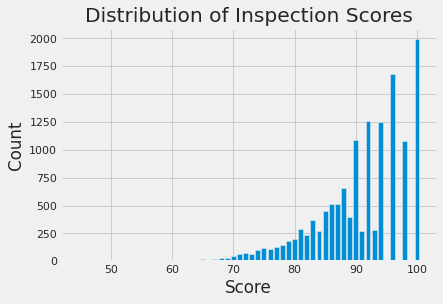

In [71]:
ins_grouped = ins.groupby("score").size()

plt.xlabel("Score")
plt.ylabel("Count")
plt.title("Distribution of Inspection Scores")
plt.bar(ins_grouped.index, ins_grouped.values)


<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<br/><br/><br/>

---

### Question 5b
Describe the qualities of the distribution of the inspections scores based on your bar plot. Consider the mode(s), symmetry, tails, gaps, and anomalous values. Are there any unusual features of this distribution? What do your observations imply about the scores?

<!--
BEGIN QUESTION
name: q5b
points: 2
manual: True
-->

The distribution of the inspections scores do not have any symmetries, but it generally follows an exponential trend. Thus, the scores that have at least 1000 counts are all >90, and the scores that have less than 10 counts are all <62. The mode is 100, minimum score is 45, and tail is at the left end of the distribution at around score 72. Some gaps exist, and they fall in the 90-100 score range. There are also some anomalous values, which are the extremely low counts for scores around 91 and 94 as compared to sorrounding scores' counts. An unusual feature is that these two unusually low frequency bins share around the same counts. My observations imply that most places would have a "passing" inspection score unless they have extreme inadequate sanitation.

<!-- END QUESTION -->



<br/><br/><br/><br/>

---

<br/><br/>

## 6: Restaurant Ratings Over Time

Let's consider various scenarios involving restaurants with multiple ratings over time.



<br/><br/><br/>

---

### Question 6a

Let's see which restaurant has had the most extreme improvement in its rating, aka scores. Let the "swing" of a restaurant be defined as the difference between its highest-ever and lowest-ever rating. **Only consider restaurants with at least 3 ratings, aka rated for at least 3 times (3 scores)!** Using whatever technique you want to use, assign `max_swing` to the name of restaurant that has the maximum swing.

*Note*: The "swing" is of a specific business. There might be some restaurants with multiple locations; each location has its own "swing".

The city would like to know if the state of food safety has been getting better, worse, or about average. This is a pretty vague and broad question, which you should expect as part of your future job as a data scientist! However for the ease of grading for this assignment, we are going to guide you through it and offer some specific directions to consider.

<!--
BEGIN QUESTION
name: q6a
points: 2
-->

In [72]:
def swing_func(df):
    return df['bid'].value_counts() >= 3
filt = ins_named.groupby(ins_named['bid']).filter(swing_func)
difference = filt['score'].groupby(ins_named['bid']).max() - filt['score'].groupby(ins_named['bid']).min()
diff_sorted = difference.sort_values(ascending=False)
df_max_res = ins_named[ins_named["bid"] == 86718]

#mask = ins_named['bid'].value_counts()>=3
#filtered_names = mask[mask].index
#filtered_df = ins_named[ins_named["name"].isin(filtered_names)]
#swing = filtered_df["score"].groupby(ins['bid']).max() - filtered_df["score"].groupby(ins['bid']).min()

#swing.sort_values(ascending=False)
#ins_named[ins_named['bid']==5819]["name"]

max_swing = ins_named[ins_named["bid"] == 86718][["name"]].squeeze().values[0]
max_swing

'Lollipot'

In [73]:
grader.check("q6a")

q6a passed!

<br/><br/><br/>

---


### Question 6b

What's the relationship between the first and second scores for the businesses with 2 inspections in a year? Do they typically improve? For simplicity, let's focus on only 2018 for this problem, using `ins2018` data frame that will be created for you below.

First, make a dataframe called `scores_pairs_by_business` indexed by `bid` (containing only businesses with exactly 2 inspections in 2018). This dataframe contains the field score_pair consisting of the score pairs ordered chronologically [first_score, second_score].

Plot these scores. That is, make a scatter plot to display these pairs of scores. Include on the plot a reference line with slope 1.

You may find the functions `sort_values`, `groupby`, `filter` and `agg` helpful, though not all necessary.

The first few rows of the resulting table should look something like:

|  **bid**   | **score_pair** |
|-----|------------|
| 48  | [94, 87]   |
| 66  | [98, 98]   |
| 146  | [81, 90]   |
| 184  | [90, 96]  |
| 273  | [83, 84]   |

In the cell below, create `scores_pairs_by_business` as described above.

Note: Each score pair must be a list type; numpy arrays will not pass the autograder.

Hint: Use the filter method from lecture 5 to create a new dataframe that only contains restaurants that received exactly 2 inspections.

Hint: Our code that creates the needed DataFrame is a single line of code that uses `sort_values`, `groupby`, `filter`, `groupby`, `agg`, and `rename` in that order. Your answer does not need to use these exact methods.

<!--
BEGIN QUESTION
name: q6bi
points: 4
-->

In [74]:
ins2018 = ins[ins['year'] == 2018]
# Create the dataframe here
scores_pairs_by_business = (ins2018.sort_values("date").groupby("bid")
                            .filter(lambda x:x["bid"].agg('count') == 2)
                            .groupby("bid").agg(lambda x: x.to_list())[["score"]]
                            .rename(columns={'score':'score_pair'}))
scores_pairs_by_business

,score_pair
bid,
48,"[94, 87]"
66,"[98, 98]"
146,"[81, 90]"
184,"[90, 96]"
273,"[83, 84]"
...,...
95621,"[100, 100]"
95628,"[75, 75]"
95674,"[100, 96]"


In [75]:
grader.check("q6bi")

q6bi passed!

<!-- BEGIN QUESTION -->

Now, create your scatter plot in the cell below. It does not need to look exactly the same (e.g., no grid) as the sample below, but make sure that all labels, axes and data itself are correct.

![](pics/7c.png)

Key pieces of syntax you'll need:

`plt.scatter` plots a set of points. Use `facecolors='none'` and `edgecolors='b'` to make circle markers with blue borders. 

`plt.plot` for the reference line.

`plt.xlabel`, `plt.ylabel`, `plt.axis`, and `plt.title`.

Hint: You may find it convenient to use the `zip()` function to unzip scores in the list.

<!--
BEGIN QUESTION
name: q6bii
points: 2
manual: True
-->

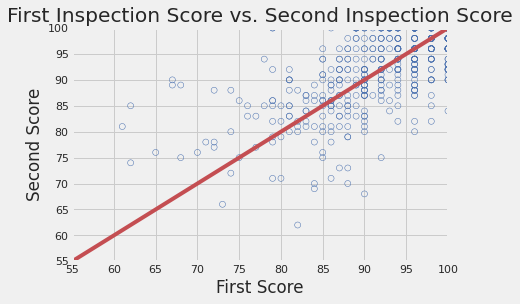

In [76]:
score1 = [scores_pairs_by_business["score_pair"].values[i][0] for i in range(len(scores_pairs_by_business))]
score2 = [scores_pairs_by_business["score_pair"].values[i][1] for i in range(len(scores_pairs_by_business))]

plt.scatter(score1, score2, facecolors='none', edgecolors='b')
plt.xlabel("First Score")
plt.ylabel("Second Score")
plt.axis([55, 100, 55, 100])
plt.title("First Inspection Score vs. Second Inspection Score")
plt.plot(plt.xlim(), plt.ylim(), color = 'r')

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<br/><br/><br/>


---


### Question 6c

If restaurants' scores tend to improve from the first to the second inspection, what do you expect to see in the scatter plot that you made in question 7c? What do you oberve from the plot? Are your observations consistent with your expectations? 

Hint: What does the slope represent?

<!--
BEGIN QUESTION
name: q6c
points: 1
manual: True
-->

The reference line of slope 1 represents the "border" where the first score is the same as the second score: if the data is below the reference line, then it shows that the restaurant score did not improve because first score > second score; likewise, if the data is above the reference line, then it shows that the restaurant score improved because first core < second score. Thus, if restaurants' scores tend to improve from the first to the second inspection, then I would expect more data to be above the reference line. From the plot, there seems to be about the same distribution above and below the reference line, with slightly more data above the line. This indicates that only a few more restaurants tend to improve than those that did not improve from the first to the second inspection. My observation is not consistent with my expectation since I would expect most restaurants to learn from their first inspection and try to improve on their second expectation. 

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<br/><br/><br/>

---

### Question 6d
To wrap up our analysis of the restaurant ratings over time, one final metric we will be looking at is the distribution of restaurant scores over time. Create a side-by-side boxplot that shows the distribution of these scores for each different risk category from 2017 to 2019. Use a figure size of at least 12 by 8.

The boxplot should look similar to the sample below. Make sure the boxes are in the correct order!

![](pics/7g.png)

**Hint**: Use `sns.boxplot()`. Try taking a look at the first several parameters. [The documentation is linked here!](https://seaborn.pydata.org/generated/seaborn.boxplot.html)

**Hint**: Use `plt.figure()` to adjust the figure size of your plot.

<!--
BEGIN QUESTION
name: q6d
points: 3
manual: True
-->

<AxesSubplot:xlabel='year', ylabel='score'>

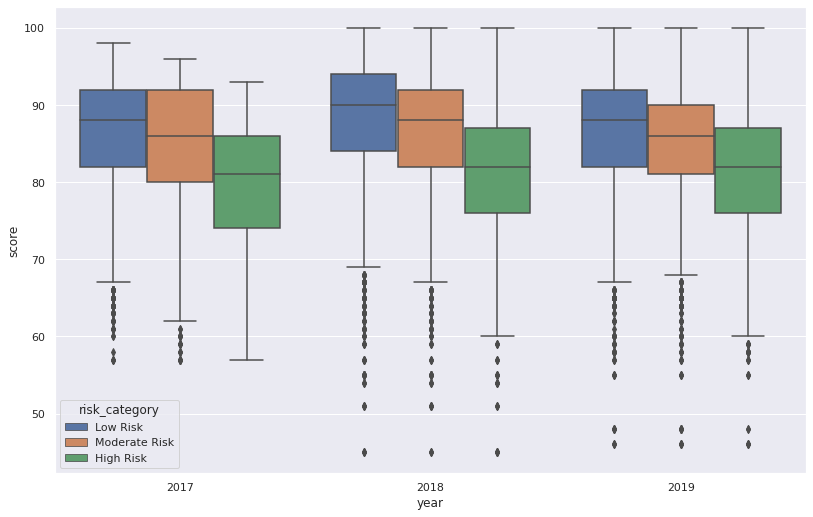

In [77]:
# Do not modify this line
sns.set()

ins_merge = ins.merge(ins2vio, how = "inner", left_on = "iid", right_on = "iid")
ins_merge_vio = ins_merge.merge(vio, how = "inner", left_on = "vid", right_on = "vid")
ins_merge_vio_year = ins_merge_vio[ins_merge_vio["year"] >= 2017]
plt.figure(figsize = (12, 8))
sns.boxplot(x = "year", y = "score", hue = "risk_category", data = ins_merge_vio_year, hue_order = ["Low Risk","Moderate Risk", "High Risk"])

<!-- END QUESTION -->



## Summary of Inspections Data

We have done a lot in this project! Below are some examples of what we have learned about the inspections data through some cool visualizations!

- We found that the records are at the inspection level and that we have inspections for multiple years.
- We also found that many restaurants have more than one inspection a year.
- By joining the business and inspection data, we identified the name of the restaurant with the worst rating and optionally the names of the restaurants with the best rating.
- We identified the restaurant that had the largest swing in rating over time.
- We also examined the change of scores over time! Many restaurants are not actually doing better.

<br/><br/><br/><br/>

---

<br/><br/>

# 7: Open Ended Question 

### Discover something interesting about the data!

<br/>

Play with the data, and try to answer one question that you find interesting regarding the data. Show us how you would answer this question through exploratory data analysis. 

Here are some possible routes you can take in completing your analysis:
* Construct a dataframe by computing something interesting about the data with methods such as `merge`/`groupby`/`pivot`, etc.
* Create a visualization with the data from which you can draw a conclusion that can answer you question.

Here are some possible questions you can ask about the data:
* How do the inspection scores relate to the geolocation (latitude, longitude) of a restaurant?
* How do all the inspection scores for each type of business change over time? 

**Note**: You are not limited to the questions we provided above. We actually strongly recommend you to explore something you are personally interested in knowing about the data. On topics such as how the socioeconomic background of the neighborhoods impact all the nearby restaurants, you are welcome to reference external sources (make sure to quote the sources) as well to guide your exploration.

Please show your work in the cells below (feel free to use extra cells if you want), and describe in words **what question you were trying to answer** and **what you found through your analysis** within the same cell. This question will be graded leniently, but good solutions may be used to create future homework problems. 

<!-- BEGIN QUESTION -->

### Grading ###

Since the question is more open ended, we will have a more relaxed rubric, classifying your answers into the following three categories:

- **Great** (4 points): 
    - For a dataframe, a combination of pandas operations (such as groupby, pivot, merge) is used to answer a relevant question about the data. The text description provides a reasonable interpretation of the result.
    - For a visualization, the chart is well designed and the data computation is correct. The conclusion based on the visualization articulates a reasonable metric and correctly describes the relevant insight and answer to the question you are interested in. 
- **Passing** (1-3 points): 
    - For a dataframe, computation is flawed or very simple. The conclusion doesn't fully address the question, but reasonable progress has been made toward answering it.
    - For a visualization, a chart is produced but with some flaws such as bad encoding. The conclusion based on the visualization is incomplete but makes some sense.
- **Unsatisfactory** (0 points): 
    - For a dataframe, no computation is performed, or the conclusion does not match what is computed at all.
    - For a visualization, no chart is created, or a chart with completely wrong results.

We will lean towards being generous with the grading. We might also either discuss in discussion or post on Piazza some exemplary analysis you have done (with your permission)!

You should have the following in your answers:
* a question you want to explore about the data.
* either of the following:
    * a few computed dataframes.
    * a few visualizations.
* a few sentences summarizing what you found based on your analysis and how that answered your question (not too long please!)

Please limit the number of your computed dataframes and visualizations **you plan on showing** to no more than 5.

Please note that you will only receive support in OH and Piazza for Matplotlib and seaborn questions. However, you may use some other Python libraries to help you create you visualizations. If you do so, make sure it is compatible with the PDF export (e.g., Plotly does not create PDFs properly, which we need for Gradescope).

<!--
BEGIN QUESTION
name: q7
points: 4
manual: True
-->

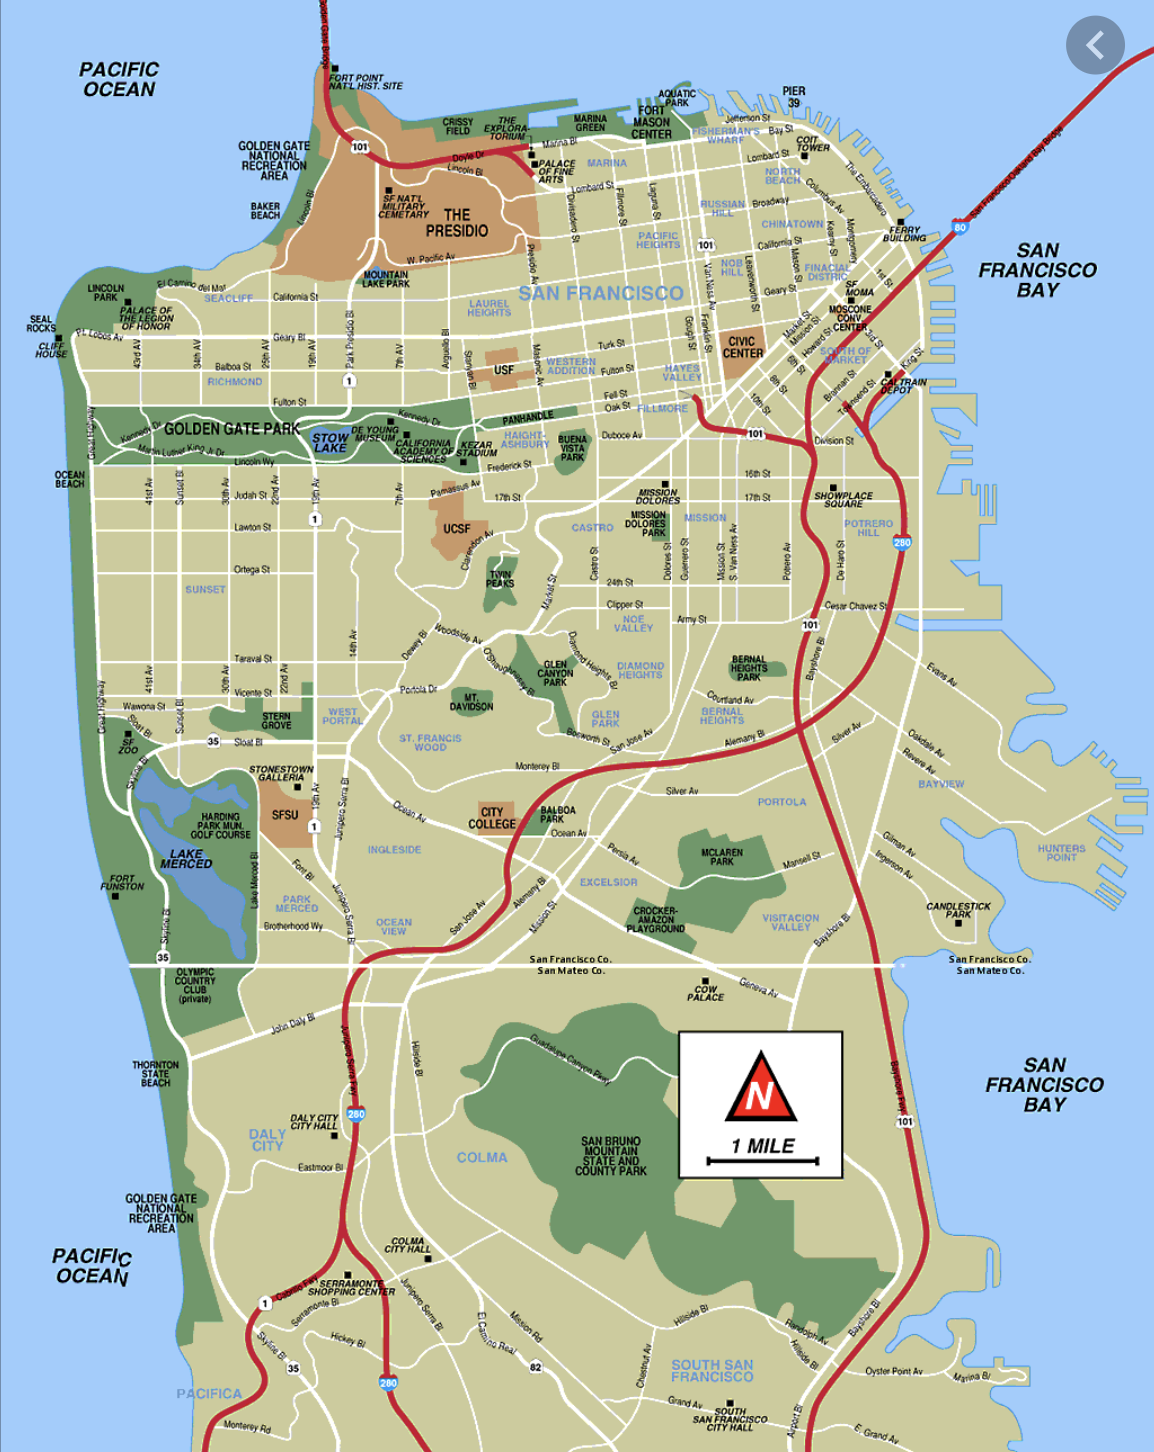

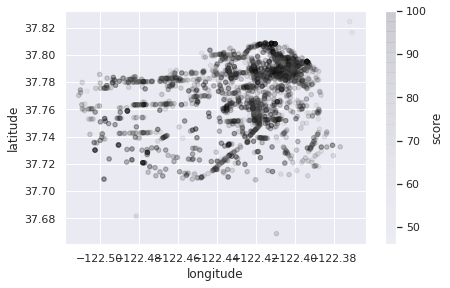

In [78]:
# YOUR QUESTION HERE (in a comment)
#How do the inspection scores relate to the geolocation (latitude, longitude) of a restaurant?

# YOUR DATA PROCESSING AND PLOTTING HERE
from mpl_toolkits.basemap import Basemap
from matplotlib.axes._axes import _log as matplotlib_axes_logger
matplotlib_axes_logger.setLevel('ERROR')

from IPython.display import Image
Image(filename='sf.png') 

#Construct a DataFrame containing only the businesses which DO NOT have valid ZIP codes.
valid_zip_bus = bus[bus["postal_code"].isin(valid_zips)]

#filter latitude and longtitude based on valid ranges 
lat_filter = valid_zip_bus[(valid_zip_bus["latitude"] >= -90) & (valid_zip_bus["latitude"] <= 90)]
long_lat_filter = valid_zip_bus[(valid_zip_bus["longitude"] >= -180) & (valid_zip_bus["longitude"] <= 180)]
merge_score = long_lat_filter.merge(ins_named, how = "inner", on = "bid")

locations = merge_score[['latitude', 'longitude']]
locationlist = locations.values.tolist()

#color density of data based on score 
merge_score = merge_score[['longitude','latitude', 'score']]    
scatterplot = merge_score.plot(kind='scatter', x="longitude", y="latitude", alpha=1/15, c=2)
scatterplot

from IPython.display import Image
Image(filename='sf.png', width=300, height=600)

# YOUR SUMMARY AND CONCLUSION HERE (in a comment)
#Based on the scatterplot, there seems to be an association between the inspection count and the inspection score. 
#Namely, that the upper right corner of the scatterplot have higher inspection frequencies and higher inspection scores. 
#This trend makes sense because from the San Francisco map displayed, we can see that the corresponding area has a 
#larger longitude and latitude degree. These regions are popular tourist spots (fisherman's wharf, civic center, 
#Chinatown) and financial districts of SF. The further away from these areas, the fewer the inspection frequency, 
#and the lower the inspection score, as illustrated in the lighter distribution around the middle and left-end of 
#the scatterplot. One inference for this observation is that restaurants in these areas typically attract more people,
#and thus might have comparatively more competition. This competition might push restaurants to maintain a higher 
#standard and therefore, a higher inspection score.

<!-- END QUESTION -->

---

To double-check your work, the cell below will rerun all of the autograder tests.

In [80]:
grader.check_all()

q1b passed!

q1c passed!

q1d passed!

q2a passed!

q2b passed!

q2ci passed!

q2cii passed!

q2d passed!

q2e passed!

q2f passed!

q3a passed!

q3bi passed!

q3bii passed!

q3biii passed!

q3ci passed!

q3cii passed!

q3ciii passed!

q3civ passed!

q3di passed!

q3dii passed!

q3e passed!

q4a passed!

q4b passed!

q4c passed!

q4d passed!

q6a passed!

q6bi passed!

## Submission

Make sure you have run all cells in your notebook in order before running the cell below, so that all images/graphs appear in the output. The cell below will generate a zip file for you to submit. **Please save before exporting!**

In [83]:
# Save your notebook first, then run this cell to export your submission.
grader.export()

<IPython.core.display.Javascript object>